<a href="https://colab.research.google.com/github/akprodromou/DWS101-Machine-Learning/blob/main/Exercise8/Exercise8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DWS101

## Exercise 8 - Artificial Neural Networks

### Εισαγωγή

Σε αυτή την εργασία θα εκπαιδεύσουμε ένα Τεχνητό Νευρωνικό Δίκτυο πολλαπλών επιπέδων (Multilayer Perceptron (MLP)) στην αναγνώριση εικόνων.


Τα δεδομένα για την εκπαίδευση και την αξιολόγηση του μοντέλου δίνονται στο [Kaggle](https://www.kaggle.com/datasets/khushikhushikhushi/dog-breed-image-dataset). Από την κάρτα δεδομένων βλέπουμε πως το σετ περιέχει εικόνες μορφής *.jpg για 10 διαφορετικές ράτσες σκύλων:

* Golden Retriever
* German Shepherd
* Labrador Retriever
* Bulldog
* Beagle
* Poodle
* Rottweiler
* Yorkshire Terrier
* Boxer
* Dachshund

Έχουμε περίπου 100 εικόνες για κάθε ράτσα, που αποθηκεύονται σε διαφορετικούς υποφακέλους (π.χ. `Golden_Retriever/`).

### Μεταφόρτωση Βιβλιοθηκών

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# maths
import random
# image manipulation
import os
import PIL
# train test
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Θέτω τις παραμέτρους για την οπτικοποίηση:

In [2]:
px.defaults.template = "plotly_white"
color_palette = ['#8c4053', '#40798C','#a170a9', '#70A9A1']
plt.rcParams["font.family"] = "sans-serif"
plt.style.use('fivethirtyeight')

### Ερωτήματα 1&2 - Εισαγωγή Δεδομένων

In [3]:
!unzip -q archive.zip

replace dataset/Beagle/Beagle_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Ας δούμε μια από τις εικόνες που περιέχονται στα δεδομένα:

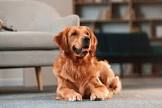

In [4]:
image_filepath = '/content/dataset/Golden_Retriever/Golden Retriever_12.jpg'
image = PIL.Image.open(image_filepath)
image

Και τις ράτσες των σκύλων που θέλουμε να προβλέψουμε:

In [5]:
breeds_names = sorted(os.listdir('dataset'))
breeds_names

['Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier']

Έχω πολλαπλές κατηγορίες, άρα στο μοντέλο μου θα έχω πολυωνυμική ταξινόμηση (multinomial classification). Θα αντιστοιχίσω επομένως τα labels από ονόματα σε αριθμητικούς δείκτες. Αυτό θα μου επιτρέψει να εντοπίζω με indexing την τιμή της softmax που αντιστοιχεί στο σωστό label, γιατί στην έξοδό της θα μου δίνει ένα διάνυσμα 10 θέσεων [0,9] με τιμές πιθανοτήτων.

In [6]:
# create a dict to assign a number to each dog breed
breeds_ids = {label: i for i, label in enumerate(breeds_names)}
breeds_ids

{'Beagle': 0,
 'Boxer': 1,
 'Bulldog': 2,
 'Dachshund': 3,
 'German_Shepherd': 4,
 'Golden_Retriever': 5,
 'Labrador_Retriever': 6,
 'Poodle': 7,
 'Rottweiler': 8,
 'Yorkshire_Terrier': 9}

### Ερώτημα 3 - Φορτώσετε τις εικόνες σε numpy arrays

Κάθε εικόνα φορτώνεται ως RGB και μετατρέπεται σε εικόνα 64x64:

In [7]:
# όπου 64 είναι ο αριθμός των pixel για κάθε εικόνα
image_size = (64, 64)

inputs = []
targets = []
for label in breeds_names:
    for filename in os.listdir(f'dataset/{label}'):
        filepath = f'dataset/{label}/{filename}'
        img = PIL.Image.open(filepath).convert('RGB').resize(image_size)
        inputs.append(img)
        targets.append(breeds_ids[label])
inputs = np.float32(inputs)
targets = np.int32(targets)

inputs.shape, targets.shape

((967, 64, 64, 3), (967,))

Από το σχήμα των arryas συμπεραίνω πως στα δεδομένα εισόδου θα δουλέψω με 967 καταγραφές, για καθεμία εκ των οποίων έχω 64 x 64 pixel με τιμή μεταξύ [0, 255] για το κάθε κανάλι (3) που αντιστοιχεί στο πρότυπο χρώματος Red, Green and Blue (RGB).

Στην έξοδο έχω την τιμή που αντιστοιχίσαμε σε κάθε ράτσα μέσω του `breeds_ids`.

Ας δούμε ένα παράδειγμα των δεδομένων εισόδου:

In [8]:
# το πρώτο pixel της πρώτης καταγραφής
inputs[0][0][0]

array([106., 124., 128.], dtype=float32)

και εξόδου:

In [9]:
print(targets[525])

5


Ας δούμε παρακάτω και την ισορροπία των δεδομένων ως προς τις μεταβλητές - στόχους:

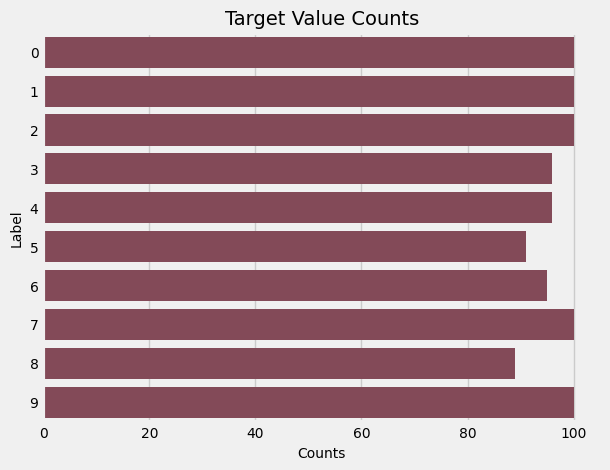

In [10]:
# η unique της numpy δίνει τη δυνατότητα count
unique, counts = np.unique(targets, return_counts=True)

ax = sns.barplot(counts, orient="h", color = color_palette[0])
ax.set_title('Target Value Counts', fontsize=14)

ax.set_xlabel("Counts", fontsize=10)
ax.set_ylabel("Label", fontsize=10)
ax.tick_params(axis='both', labelsize=10)

plt.show()

Από το διάγραμμα συμπεραίνουμε πως έχουμε γενικά ισορροπημένη κατανομή των μεταβλητών - στόχων. Χωρίζω σε δεδομένα εκπαίδευσης και δοκιμής με split 80%-20%:

In [11]:
seed = 5

test_size = 0.2

x_train_full, x_test, y_train_full, y_test = train_test_split(
    inputs,
    targets,
    test_size=test_size,
    random_state=seed
)

x_train_full.shape, y_train_full.shape, x_test.shape, y_test.shape

((773, 64, 64, 3), (773,), (194, 64, 64, 3), (194,))

Στη συνέχεια θα δημιουργήσω και ένα validation set (20% του train set), πάνω στο οποίο θα γίνει το tuning του μοντέλου. Το test set θα το κρατήσω μόνο για την τελική αξιολόγησή του:

In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full,
    y_train_full,
    test_size=0.2,
    random_state=seed,
    stratify=y_train_full
)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((618, 64, 64, 3), (618,), (155, 64, 64, 3), (155,))

Τα δεδομένα μας είναι στη μορφή (N, Height, Width, Channels):

Όπου:

N = ο αριθμός των δειγμάτων (676)

H, W = ύψος και πλάτος της κάθε εικόνας

C = τα κανάλια

#### Data Preprocessing

**Δεδομένα Εισόδου**

Από τη θεωρία γνωρίζουμε πως όταν δουλεύουμε με νευρωνικά δίκτυα, ένας συνηθισμένος κίνδυνος είναι η εκτίναξη ή η εξαφάνιση των παραγώγων $d{E}/d{w_i}$ καθώς εκτελούμε την Ανάστροφη Μετάδοση Λάθους (Back Propagation) από το τελευταίο (output layer) προς το πρώτο στρώμα (input layer) του δικτύου. Πιο συγκεκριμένα:

* Vanishing Gradient (Εξαφανιζόμενη Κλίση): Όταν έχουμε ως συνάρτηση ενεργοποίησης τη σιγμοειδή ή την υπερβολική εφαπτομένη οι υψηλές τιμές σε input οδηγούν σε κλίση σχεδόν μηδενική (οριζόντια δηλαδή). Επομένως πολλαπλασιαζόμενοι κατά την οπίσθια τροφοδότηση από στρώμα σε στρώμα οδηγούν σε πολυ μικρή διόρθωση των βαρών, με αποτέλεσμα το δίκτυο να μαθαίνει εξαιρετικά αργά.

* Exploding Gradient (Εκρηγνυόμενη Βαθμίδα): σε αυτή την περίπτωση εάν οι τιμές εισόδου έχουν μεγάλες τιμές (>1), οι κλίσεις μεγαλώνουν μέχρι αναπόφευκτα να φτάσουν σε πάρα πολύ μεγάλες τιμές και να προκαλέσουν κατάρρευση του μοντέλου.

Υψηλές τιμές των εισόδων μπορούν επίσης να οδηγήσουν σε αστάθεια του μοντέλου, δηλαδή οι μεταβολές που προκύπτουν για τη διόρθωση των βαρών να είναι πολύ μεγάλες, και έτσι να αργήσει το μοντέλο να καταλήξει σε βέλτιστα βάρη - με συνέπειες σε χρόνο και κόστος.

Ένας από τους τρόπους αντιμετώπισης των παραπάνω είναι η κανονικοποίηση των δεδομένων εισόδου. Για να την εφαρμόσουμε στο συγκεκριμένο σετ θα διαιρέσουμε με το 255· καθώς οι τιμές RGB για κάθε pixel κυμαίνονται μεταξύ 0 και 255, με τη διαίρεση θα μεταφερθουν στο εύρος [0,1].

In [13]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

**Δεδομένα Εξόδου**

Καθώς η έξοδος είναι πολυωνυμική κατηγορική μεταβλητή, θα χρησιμοποιήσω ως συνάρτηση ενεργοποίησης τη softmax, που θα μου δώσει ένα διάνυσμα μήκους 10 θέσεων με την πιθανοτική κατανομή για κάθε label, π.χ. [0.01, 0.005, ... , 0.08]. Για να μπορέσω εν συνεχεία να υπολογίσω το σφάλμα, πρέπει η πραγματική ετικέτα να δίνεται και αυτή στην ίδια μορφή (τώρα δίνεται απλά με το index του σωστού label, π.χ. `8`). Επομένως θα χρησιμοποιήσω την συνάρτηση `to_categorical()` της keras, για να μετατρέψω τα targets από ακέραιες τιμές σε έναν πίνακα one-hot encoding, όπου με `1` θα σημειώνεται η σωστή ετικέτα, και όλες οι άλλες θα σημειώνονται με `0`:

In [14]:
y_train = to_categorical(y_train)

In [15]:
# ο πίνακας για σωστή ετικέτα το 'Labrador_Retriever': 6
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [16]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

Όμοια και για τα test και validation sets:

In [17]:
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [18]:
# check
y_train.shape, y_test.shape, y_val.shape

((618, 10), (194, 10), (155, 10))

### Ερώτημα 4 - Δημιουργήστε το Τεχνητό Νευρωνικό Δίκτυο Πολλών Επιπέδων (MLP) και αναλύστε την αρχιτεκτονική του (είδος επιπέδου, πλήθος εισόδων και εξόδων ανά επίπεδο και συνάρτηση ενεργοποίησης των επιπέδων).

Για το Multi-Layer Perceptron μοντέλο θα επιλέξω την παρακάτω αρχιτεκτονική:

- Στο Input layer προσδιορίζω τη μορφή των δεδομένων μου και αρχικοποιεί έναν τανυστή. Σύμφωνα με το [documentation της keras](https://www.tensorflow.org/api_docs/python/tf/keras/Input), στο input δεν δίνω το batch size, αλλά μόνο τις διαστάσεις των επιμέρους στοιχείων, άρα `x_train.shape[1:]`.
- Επιπεδοποίηση (καθώς δεν μπορώ να δουλέψω με 2D πίνακες στα MLP), όπου μετατρέπω το input σε ένα διάνυσμα μήκους 64 x 64 x 3 = 12288. Αυτοί είναι και οι κόμβοι του input layer.
- Δύο hidden layers. Εδώ θα εφαρμόσω τον εμπειρικό κανόνα για προβλήματα ταξινόμησης, με αριθμό νευρώνων (units) στα κρυφά επίπεδα < αριθμό παραδειγμάτων εκπαίδευσης (για να αποφευχθεί η αποκλειστική συσχέτιση ενός κρυφού νευρώνα με ένα παράδειγμα εκπαίδευσης). Επιπλέον, οι νευρώνες θα ξεκινούν από περισσότερες κεφαλές (πιο πλούσια πληροφορία) καταλήγοντας σε λιγότερες, ακολουθώντας τη λογική της γενίκευσης της πληροφορίας. Θέτω επομένως το πρώτο στρώμα 128 κεφαλών και το δεύτερο 64 κεφαλών. Ως συνάρτηση ενεργοποίησης θα χρησιμοποιήσουμε τη ReLU, για να αντιμετωπίσουμε το Vanishing Gradient.
- Activation με softmax εφόσον έχω πολυωνυμική κατηγοριοποίηση στο target.



In [19]:
# από το input αφαιρώ τον αριθμό των δεδομένων (batch)
input_data = x_train.shape[1:]

# η Sequential ομαδοποιεί στοίβες στρώσεων στο μοντέλο
mlp = tf.keras.Sequential([
    # δηλώνω τη μορφή των δεδομένων που λαμβάνω ως input
    tf.keras.layers.Input(shape=input_data),
    # μετατρέπω τον τανυστή των input σε ένα διάνυσμα μήκους 64 x 64 x 3 = 12288
    tf.keras.layers.Flatten(),
    # αναπαραστάσεις πιο ειδικής πληροφορίας
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    # αναπαραστάσεις πιο γενικής πληροφορίας
    tf.keras.layers.Dense(units=64, activation='relu', use_bias=True),
    # προσδιορίζω τον αριθμό των κατηγοριών στην έξοδο (n = 10)
    tf.keras.layers.Dense(units=len(breeds_names), activation='softmax', use_bias=True)
], name='MLP')

In [20]:
mlp.summary()

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,898 (6.03 MB)

 Trainable params: 1,581,898 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

**Σχόλια**

- Στην στρώση της επιπέδωσης δημιουργούνται διανύσματα μήκους 64 x 64 x 3 = 12288. Δεν έχω παραμέτρους επειδή δεν έχω κεφαλές, απλά μετατρέπω τον τανυστή σε διάνυσμα.
- Στο πρώτο dense layer έχω 12288 (είσοδοι) x 128 (βάρη) + 128 (bias) παραμέτρους (κεφαλές).
- Παρόμοια, στο δεύτερο dense layer έχω 128 (εισερχόμενα) x 64 + 64 (και πάλι το bias) = 8256 παραμέτρους, άρα μια συμπίεση της πληροφορίας.
- Τέλος στο τρίτο dense layer που είναι και η έξοδός μου έχω 64 (εισερχόμενα) x 10 (κεφαλές εξόδου) + 10 (bias) = 650 παραμέτρους.

### Ερώτημα 5 - Εκπαίδευση μοντέλου

Από την εκφώνηση ζητείται:

* Optimizer: Adam. Οι βελτιστοποιητές (Optimizers) είναι οι αλγόριθμοι που ακολουθεί το μοντέλο για την ελαχιστοποίηση της συνάρτησης απωλειών (loss function).

* Learning Rate: 0.001. Είναι ο ρυθμός αλλαγής των βαρών (ρυθμός μάθησης).
* Loss Function: Categorical Cross-Entropy. Η συνάρτηση κόστους διεντροπίας χρησιμοποιείται για κατηγορική ταξινόμηση και μειώνεται όσο αυξάνεται η πιθανότητα που δίνει το μοντέλο στην σωστή ετικέτα, στο εύρος [0,1].
* Batch Size: 32. Η παράμετρος μέγεθος παρτίδας (δέσμης) καθορίζει τον αριθμό των δειγμάτων τα οποία επεξεργάζονται μαζί, πριν την ενημέρωση των βαρών του μοντέλου κατά το πέρασμα προς τα πίσω στην εκπαίδευσή του. Εν προκειμένω, 32 δείγματα θα επεξεργάζονται παράλληλα (χρησιμοποιώντας 32 νήματα της GPU) και για την ενημέρωση των βαρών θα χρησιμοποιείται ο μέσος όρος των δειγμάτων ανά δέσμη.
* Epochs: 30. Ως «epoch» ορίζεται ένας κύκλος εκπαίδευσης, δηλαδή το πλήρες πέρασμα του μοντέλου από όλα τα δεδομένα εκπαίδευσης, το οποίο εν προκειμένω προκαθορίζουμε στις 30 επαναλήψεις.

In [21]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
mlp.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
batch_size = 32
epochs = 30

Ξεκινάμε με την εκπαίδευση του μοντέλου:

In [23]:
history_mlp = mlp.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val)
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.0827 - loss: 4.4739 - val_accuracy: 0.1548 - val_loss: 2.2978
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1970 - loss: 2.2401 - val_accuracy: 0.3677 - val_loss: 1.9241
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3125 - loss: 1.9267 - val_accuracy: 0.2645 - val_loss: 2.0501
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3851 - loss: 1.8244 - val_accuracy: 0.4387 - val_loss: 1.6364
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6162 - loss: 1.3961 - val_accuracy: 0.4516 - val_loss: 1.6393
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5913 - loss: 1.3647 - val_accuracy: 0.4194 - val_loss: 1.6947
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5705 - loss: 1.3061 - val_accuracy: 0.6452 - val_loss: 1.3725
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7228 - loss: 1.0676 - val_accuracy: 0.5419 - v

**Σχόλιο**

Παρατηρούμε πως είναι αξιοσημείωτη η ταχύτητά του μοντέλου: κάθε κύκλος χρειάζεται περίπου 1 δευτερόλεπτο, που προκύπτει ως εξής (π.χ. για τον έκτο κύκλο):

967 (δεδομένα) / 32 (δέσμες) * 0.025 ms (ανά δέσμη) = 0.76 seconds

Ας δούμε τις προβλέψεις του MLN μοντέλου και στο test set:

In [24]:
# get predictions
y_pred_mlp = mlp.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [25]:
y_pred_mlp[0]

array([5.7598795e-03, 5.4820545e-04, 6.4865237e-01, 2.3471614e-02,
       1.7639775e-03, 1.0400701e-03, 3.1393465e-01, 6.1681733e-04,
       1.4775934e-03, 2.7348287e-03], dtype=float32)

In [26]:
y_test[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

Για να μπορέσω να συγκρίνω τις προβλέψεις πιθανοτήτων με τις πραγματικές ετικέτες θα χρησιμοποιήσω και πάλι την `to_categorical()` της keras:

In [27]:
y_pred_onehot = tf.keras.utils.to_categorical(np.argmax(y_pred_mlp, axis=1), num_classes=len(breeds_names))

In [28]:
y_pred_onehot[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
print("MLP Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_onehot, axis=1)))

MLP Confusion Matrix:
[[14  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  1  0  0  0]
 [ 0  3  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0]
 [ 0  0  0  2  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0 25]]


Από το confusion matrix βλέπω πως έχω (194-6)/(194) = 96.9% ακρίβεια

In [30]:
test_loss_mlp, test_acc_mlp = mlp.evaluate(x_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9598 - loss: 0.3802 


In [31]:
print(f"MLP Test Loss: {test_loss_mlp:.4f}")
print(f"MLP Test Accuracy: {test_acc_mlp:.4f}")

MLP Test Loss: 0.3625
MLP Test Accuracy: 0.9691


**Σχόλιο**

Η τελική ακρίβεια του μοντέλου είναι:

- Training accuracy: 1.0000
- Validation accuracy: 0.9545
- Test accuracy: 0.9691

Το οποίο κρίνεται ως πολύ καλό αποτέλεσμα για την ακρίβεια σε άγνωστα δεδομένα - με δεδομένο πως αφορά την σωστή εκτίμηση σκύλων σε φωτογραφίες, δηλαδή το περιθώριο λάθους 3-4% είναι ανεκτό.

### Ερώτημα 6 - Εμφανίστε το loss history καθώς και το accuracy history για τα δεδομένα train, test

**Α' Ερμηνεία ερωτήματος**

Αν αναφερόμαστε πράγματι στο test set, αυτό τρέχει μόνο μια φορά άρα δεν είναι διαθέσιμη η έννοια του history ανά epoch, όπως ισχύει για τα train και το validation set. Οπότε συγκρίνοντας την τελική ακρίβεια και την απώλεια στο training set με τις μοναδικές τιμές του test, θα έχουμε:

In [32]:
train_loss_mlp, train_acc_mlp = mlp.evaluate(x_train, y_train, verbose=0)

In [33]:
print(f"MLP - Final Train Loss: {train_loss_mlp:.4f}, MLP - Final Train Accuracy: {train_acc_mlp:.4f}")

MLP - Final Train Loss: 0.0533, MLP - Final Train Accuracy: 1.0000


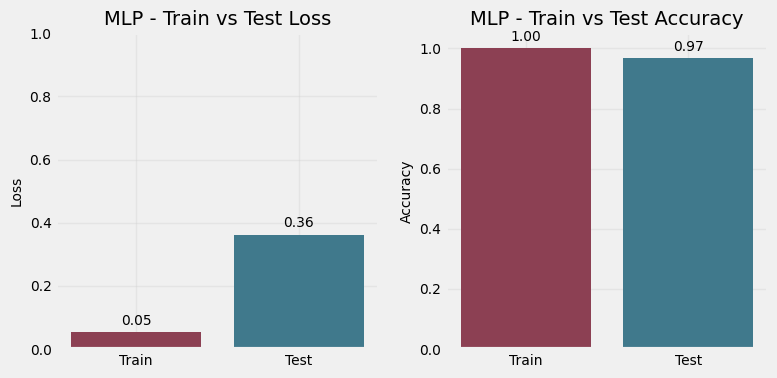

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Loss comparison
sets = ['Train', 'Test']
losses = [train_loss_mlp, test_loss_mlp]
bars = ax1.bar(sets, losses, color=[color_palette[0], color_palette[1]])
ax1.set_ylabel('Loss', fontsize=10)
ax1.set_title('MLP - Train vs Test Loss', fontsize=14)
ax1.tick_params(axis='both', labelsize=10)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
ax1.bar_label(bars, fmt='%.2f', padding=3, fontsize=10)

# Accuracy comparison
accuracies = [train_acc_mlp, test_acc_mlp]
bars = ax2.bar(sets, accuracies, color=[color_palette[0], color_palette[1]])
ax2.set_ylabel('Accuracy', fontsize=10)
ax2.set_title('MLP - Train vs Test Accuracy', fontsize=14)
ax2.tick_params(axis='both', labelsize=10)
ax2.grid(True, alpha=0.3)
ax2.bar_label(bars, fmt='%.2f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

**Σχόλιο**

Πετυχαίνουμε απόλυτη ακρίβεια στο training set, ενώ και στο test set η ακρίβεια είναι 96.9%, που είναι επίσης υψηλή - δεδομένου του σκοπού, που είναι η αναγνώριση σκύλων σε φωτογραφίες. Η απώλεια στο test set είναι σημαντικά μεγαλύτερη (32% έναντι 3%) και η εξήγηση είναι πως η Categorical Entropy Loss δίνεται από τον παρακάτω τύπο:

$$L(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} y_i \log(\hat{y}_i)$$

όπου με $\hat{y}_i$ δίνεται η πιθανότητα της σωστής κλάσης που έβγαλε το μοντέλο. Όσο λοιπόν πιο σίγουρο είναι το μοντέλο στο λάθος που κάνει, τόσο μικρότερη είναι η πιθανότητα που δίνει στη σωστή ετικέτα, με αποτέλεσμα ο λογάριθμός της να αυξάνεται (log(0.1) > log(0.9)). Αντίθετα, εάν δώσει πιθανότητα ίση με 1 στη σωστή ετικέτα, ο λογάριθμος - και άρα και η απώλεια - είναι ίσα με μηδέν.

**Β' Ερμηνεία ερωτήματος**

Εάν αναφερόμαστε στην μεταβολή της ακρίβειας και των απωλειών του training vs validation set, τότε διαθέτουμε history, το οποίο είναι:

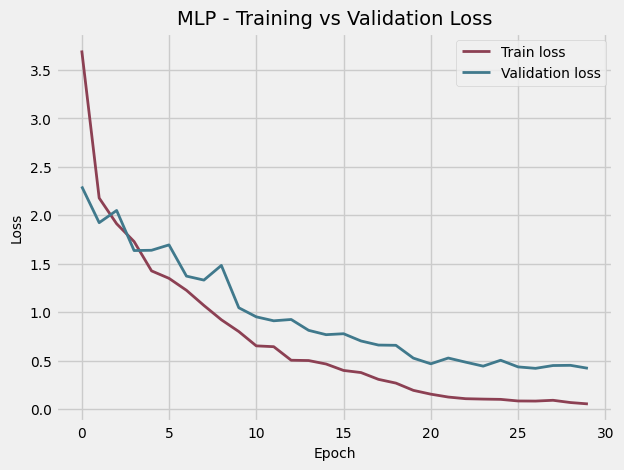

In [35]:
plt.figure()
plt.plot(history_mlp.history['loss'], label='Train loss', color=color_palette[0], linewidth=2)
plt.plot(history_mlp.history['val_loss'], label='Validation loss', color=color_palette[1], linewidth=2)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('MLP - Training vs Validation Loss', fontsize=14)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

Από το διάγραμμα παρατηρούμε πως καθώς πλησιάζουμε στους 30 κύκλους εκπαίδευσης, η απώλεια προσεγγίζει στο 0 για τα δεδομένα εκπαίδευσης και φαίνεται να σταθεροποιείται στο 0.4 για τα δεδομένα επικύρωσης.

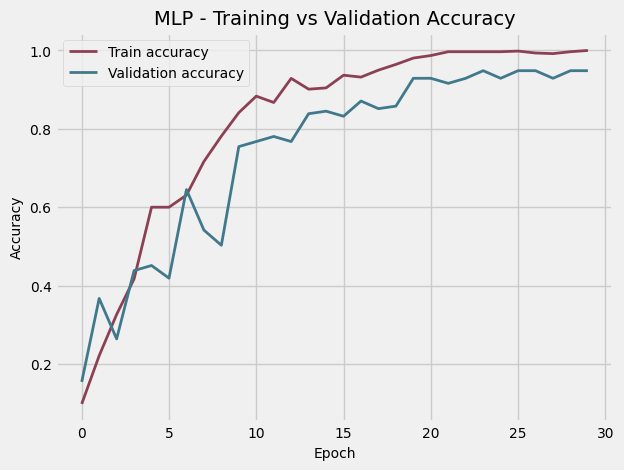

In [36]:
plt.figure()
plt.plot(history_mlp.history['accuracy'], label='Train accuracy', color=color_palette[0], linewidth=2)
plt.plot(history_mlp.history['val_accuracy'], label='Validation accuracy', color=color_palette[1], linewidth=2)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('MLP - Training vs Validation Accuracy', fontsize=14)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

**Σχόλιο**

Αντίστοιχα, βλέπουμε πως, και η ακρίβεια, καθώς πλησιάζουμε στον 30ο κύκλο εκπαίδευσης φτάνει στο 1 για τα δεδομένα εκπαίδευσης και σταθεροποιείται περίπου στο 0.95 για τα δεδομένα επικύρωσης.

### Ερώτημα 7 - Επαναλάβετε τα ερωτήματα 6 ως 8 χρησιμοποιώντας Convolutional Neural Network (CNN). Στη συνέχεια, να εξηγήσετε ποιο μοντέλο είναι καλύτερο.

Στα Συνελικτικά Νευρωνικά Δίκτυα (CNN) η κύρια ιδέα είναι αυτή της συνέλιξης, όπου τα δεδομένα εισόδου σαρώνονται διαδοχικά και στα οποία εφαρμόζονται φίλτρα, δηλαδή πολλαπλασιάζονται με πίνακες με βάρη (kernels).

Ο πυρήνας αυτός μετακινείται σε ολόκληρη την επιφάνεια της εικόνας, και το αποτέλεσμα είναι ένας νέος χάρτης χαρακτηριστικών, στον οποίο αποτυπώνονται οι περιοχές όπου το εκάστοτε φίλτρο ανιχνεύει την παρουσία συγκεκριμένων μοτίβων.

Βασικές έννοιες αποτελούν:

- Το μέγεθος του πυρήνα, συνήθως διαστάσεων 3 x 3 ή 5 x 5.

- Το βήμα (stride) προσπέλασης του φίλτρου.

- Padding, που είναι η δημιουργία ενός περιγράμματος σε κάθε στρώμα, που επιτρέπει α) στα περιμετρικά pixel να διαβάζονται σε πολλαπλές προσπελάσεις του φίλτρου και όχι μόνο μια φορά, χρησιμοποιώντας έτσι την πληροφορία που περιέχουν και β) να μην έχουμε μεγάλη συρρίκνωση (dimensionality reduction) των χαρακτηριστικών καθώς προχωράμε στα επόμενα στρώματα.

- Την ομαδοποίηση (pooling), δηλαδή τον συνδυασμό των φίλτρων και συνεπαγόμενα τη μείωση των χωρικών διαστάσεων των χαρακτηριστικών, βοηθώντας στη μείωση των παραμέτρων και της υπολογιστικής πολυπλοκότητας.

Για την εφαρμογή μας θα διαλέξω:

- Πυρήνα 3 x 3 - καθώς με διαστάσεις 64 x 64 ίσως ένας πυρήνας 5 x 5 να ήταν πολύ μεγάλος
- Initial layers: Από τη θεωρία γνωρίζουμε πως στα πρώτα στρώματα χρειαζόμαστε λιγότερα σχετικά φίλτρα, για να εντοπίσουν βασικά, απλούστερα χαρακτηριστικά. Επιλέγω τα 32, και εφαρμόζω padding για τους λόγους που προαναφέραμε, με την επιλογή `same`, ώστε ο χάρτης των χαρακτηριστικών να παραμείνει ίδιος.
- Στο τέλος αυτής της στρώσης εφαρμόζω Pooling, το οποίο οδηγεί σε μείωση της διαστασιμότητας, ομαδοποιώντας τα δεδομένα σε ένα παράθυρο 2 x 2, παίρνοντας τη μέγιστη τιμή τους (`MaxPooling`).
- Deeper layers: Στη δεύτερη σειρά από layers, θα αυξήσω τα φίλτρα από 32 σε 64, γιατί θέλω να εντοπίσω πιο σύνθετα χαρακτηριστικά.
- Flatten layer: Μετά τα παραπάνω στρώματα που ανήκουν στο Convolution, θα μεταβώ στην διαδικασία της ταξινόμησης, που γίνεται με το Multi Layer Perceptron. Όπως είδαμε και νωρίτερα, δεν παίρνει 2D πίνακες, οπότε κάνω επιπεδοποίηση των δεδομένων.
- Ακολουθούν τα `Dense layers` του MLP. Το πρώτο έχει 128 φίλτρα και στην ουσία «συμπιέζει» την πληροφορία που παίρνει από το επιπεδωμένο στρώμα. Το δεύτερο έχει τόσα φίλτρα όσα και οι ετικέτες ταξινόμησης, δηλαδή 10 (`len(breeds_names)`).
- Ανάμεσά τους παρεμβάλλεται ένα dropout layer. Αυτό απενεργοποιεί τυχαία το 30% των νευρώνων κάθε batch, με σκοπό να αναγκαστεί το μοντέλο να χρησιμοποιήσει - και άρα να βελτιστοποιήσει - όλα τα βάρη του, αποφεύγοντας την υπερπροσαρμογή.

In [37]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_data),

    # πρώτη σειρά
    # θέτω padding='same' για να διατηρήσω το μέγεθος του input
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', strides=1, activation='relu', use_bias=True),
    # downscale by a factor of 2, taking the maximum value over a 2x2 input window
    tf.keras.layers.MaxPooling2D(2),

    # δεύτερη σειρά
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2),

    # επιπεδοποίηση που απαιτείται για τα MLP
    tf.keras.layers.Flatten(),

    # fully connected layers (MLP)
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=len(breeds_names), activation='softmax', use_bias=True)
], name='CNN')
cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117,962 (8.08 MB)

 Trainable params: 2,117,962 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

**Σχόλιο**

- Στην πρώτη στρώση έχω 32 φίλτρα διαστάσεων 3 x 3, άρα 32x9 = 288 παράμετροι. Αυτοί εφαρμόζονται σε 3 κανάλια (η κωδικοποίηση της RGB) άρα 288x3 = 864 παράμετροι. Σύμφωνα με το [documentation](https://keras.io/api/layers/convolution_layers/convolution2d/) προστίθεται και ένας όρος για το bias για κάθε φίλτρο, άρα 864 + 1 * 32 φίλτρα = 896 παράμετροι.
- Στο δεύτερο φίλτρο έχω 32 εισόδους x 3 x 3 (kernel) x 64 εξόδους = 18432, στις οποία προσθέτω και 64 bias = 18496 παράμετροι.
- Παρατηρώ πως όποτε εφαρμόζεται το pooling έχω μείωση των διαστάσεων κατά το ήμισυ (64 σε 32, 32 σε 16).

Και ας τρέξουμε το μοντέλο:

In [38]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val)
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.1280 - loss: 2.4377 - val_accuracy: 0.1871 - val_loss: 2.2531
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.2244 - loss: 2.1736 - val_accuracy: 0.3097 - val_loss: 1.9486
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.4652 - loss: 1.6900 - val_accuracy: 0.5613 - val_loss: 1.4586
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.7079 - loss: 1.0013 - val_accuracy: 0.7484 - val_loss: 0.8940
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.8852 - loss: 0.4611 - val_accuracy: 0.8645 - val_loss: 0.5804
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.9405 - loss: 0.2749 - val_accuracy: 0.9290 - val_loss: 0.5079
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.9528 - loss: 0.1930 - val_accuracy: 0.9419 - val_loss: 0.4600
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.9756 - loss: 0.1092 - val_accuracy: 0.

Από τα αποτελέσματα βλέπω πως πετυχαίνω πολυ υψηλή ακρίβεια και εδώ, με 100% στα δεδομένα εκπαίδευσης και 95.5% στα δεδομένα απικύρωσης. Ξεχωρίζει όμως το γεγονός πως για κάθε κύκλο χρειαζόμαστε περίπου 7-8 φορές παραπάνω έναντι του MLP (από ~0.7 σε 4-5 seconds).

Τα αποτελέσματά μου για training και validation είναι:

In [39]:
train_loss_cnn, train_acc_cnn = cnn.evaluate(x_train, y_train, verbose=0)

Ενώ για το test set έχω:

In [40]:
test_loss_cnn, test_acc_cnn = cnn.evaluate(x_test, y_test, verbose=0)

print(f"CNN - Test Loss: {test_loss_cnn:.4f}")
print(f"CNN - Test Accuracy: {test_acc_cnn:.4f}")

CNN - Test Loss: 0.5725
CNN - Test Accuracy: 0.9691


**Σύγκριση Training - Test set**

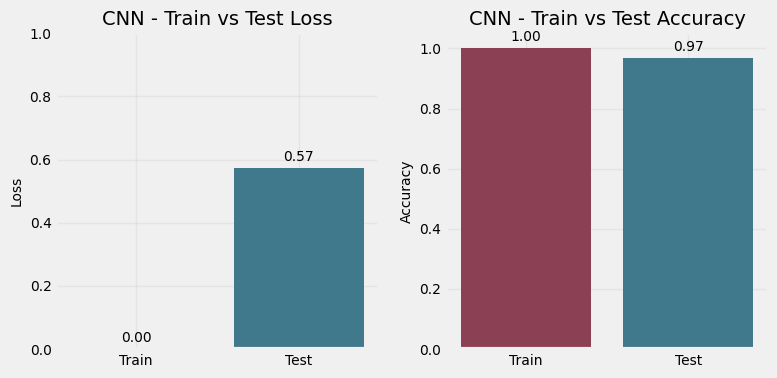

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Loss comparison
sets = ['Train', 'Test']
losses = [train_loss_cnn, test_loss_cnn]
bars = ax1.bar(sets, losses, color=[color_palette[0], color_palette[1]])
ax1.set_ylabel('Loss', fontsize=10)
ax1.set_title('CNN - Train vs Test Loss', fontsize=14)
ax1.tick_params(axis='both', labelsize=10)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
ax1.bar_label(bars, fmt='%.2f', padding=3, fontsize=10)

# Accuracy comparison
accuracies = [train_acc_cnn, test_acc_cnn]
bars = ax2.bar(sets, accuracies, color=[color_palette[0], color_palette[1]])
ax2.set_ylabel('Accuracy', fontsize=10)
ax2.set_title('CNN - Train vs Test Accuracy', fontsize=14)
ax2.tick_params(axis='both', labelsize=10)
ax2.grid(True, alpha=0.3)
ax2.bar_label(bars, fmt='%.2f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

**Σχόλιο**

Τα αποτελέσματα είναι ίδια (!) με το απλό νευρωνικό πολλών επιπέδων στην ακρίβεια (0.9691), με αύξηση στην απώλεια (0.57 έναντι 0.32).

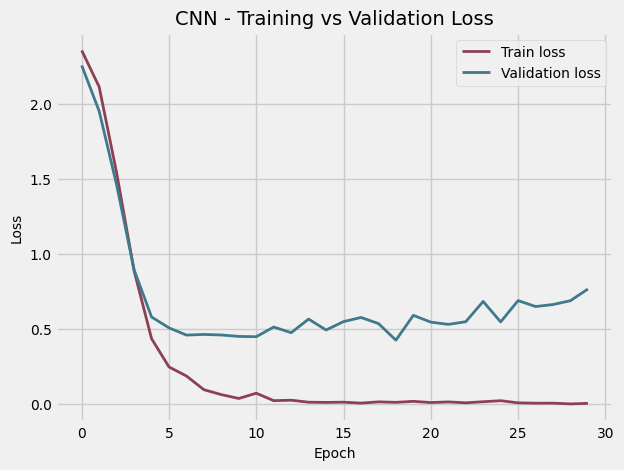

In [42]:
plt.figure()
plt.plot(history_cnn.history['loss'], label='Train loss', color=color_palette[0], linewidth=2)
plt.plot(history_cnn.history['val_loss'], label='Validation loss', color=color_palette[1], linewidth=2)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('CNN - Training vs Validation Loss', fontsize=14)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

Από το διάγραμμα βλέπω πως μετά τον 11ο-12ο κύκλο δεν έχουμε βαλτίωση στην ακρίβεια, ενώ η αύξηση της σιγουριάς των λάθος προβλέψεων του μοντέλου οδηγεί και σε αύξηση των απωλειών.

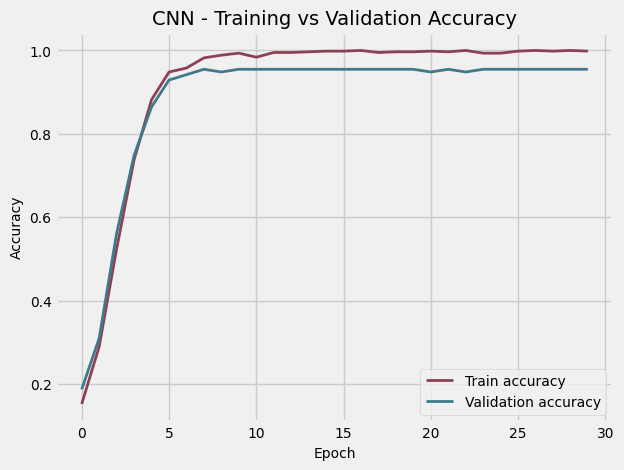

In [43]:
plt.figure()
plt.plot(history_cnn.history['accuracy'], label='Train accuracy', color=color_palette[0], linewidth=2)
plt.plot(history_cnn.history['val_accuracy'], label='Validation accuracy', color=color_palette[1], linewidth=2)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('CNN - Training vs Validation Accuracy', fontsize=14)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

**Σύγκριση MLP και CNN**

* Στην περίπτωση του CNN παρατηρούμε πως η σταθεροποίηση ξεκινάει πολύ νωρίτερα έναντι του MLP, στους 11-12 κύκλους (έναντι 30).

* Όμοια και στην ακρίβεια, φτάνουμε στα μέγιστα αποτελέσματα πριν τον 10 κύκλο εκπαίδευσης.

### Ερώτηση 8 - Εφαρμόστε όποια άλλη τεχνική θέλετε για να βελτιώσετε την ακρίβεια του CNN! Μπορείτε να δοκιμάσετε Standard Scaling, Batch Normalization, Hyperparameter Tuning κλπ.

Θα δοκιμάσουμε να ξανατρέξουμε το μοντέλο με τις εξής αλλαγές:

- Batch Normalization (Κανονικοποίησης Παρτίδας): Κανονικοποιεί τα δεδομένα με μέση τιμή = 0 και διακύμανση = 1 ώστε οι είσοδοι σε κάθε στρώμα να παρουσιάζουν παρόμοια κατανομή, καθώς τα βάρη μεταβάλλονται με κάθε batch run.
- Μεγαλώνω το μέγεθος των πυρήνων από 3x3 σε 5x5.
- Προσθέτω μια τρίτη σειρά με 128 φίλτρα.
- Hyperparameter tuning αλλάζοντας τον ρυθμό μάθησης από 0.001 σε 10^-4 (μικρότερα βήματα δηλαδή).

In [44]:
cnn_rev = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_data),

    # πρώτη σειρά
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', strides=1, activation='relu', use_bias=True),
    # κανονικοποίηση
    tf.keras.layers.BatchNormalization(),
    # downscale by a factor of 2, taking the maximum value over a 2x2 input window
    tf.keras.layers.MaxPooling2D(2),

    # δεύτερη σειρά
    # θέτω padding='same' για να διατηρήσω το μέγεθος του input
    tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', strides=1, activation='relu', use_bias=True),
    # downscale by a factor of 2, taking the maximum value over a 2x2 input window
    tf.keras.layers.MaxPooling2D(2),

    # τρίτη σειρά
    tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding='same', strides=1, activation='relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2),

    # απαιτούμενη επιπεδοποίηση
    tf.keras.layers.Flatten(),

    # fully connected layers (MLP)
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=len(breeds_names), activation='softmax', use_bias=True)
], name='CNN')
cnn_rev.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,308,746 (4.99 MB)

 Trainable params: 1,308,682 (4.99 MB)

 Non-trainable params: 64 (256.00 B)

In [45]:
optim_rev = tf.keras.optimizers.Adam(learning_rate=0.0005)
cnn_rev.compile(optimizer=optim_rev, loss='categorical_crossentropy', metrics=['accuracy'])
# δεν χρειάζονται 30 epochs, εφόσον σταθεροποιούνται τα αποτελέσματα νωρίτερα
epochs = 20
batch_size = 32

history_cnn_rev = cnn_rev.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val)
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 714ms/step - accuracy: 0.1854 - loss: 2.3994 - val_accuracy: 0.1871 - val_loss: 2.2834
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 692ms/step - accuracy: 0.4031 - loss: 1.6924 - val_accuracy: 0.1806 - val_loss: 2.2414
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 667ms/step - accuracy: 0.6550 - loss: 1.0806 - val_accuracy: 0.5226 - val_loss: 2.1174
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 698ms/step - accuracy: 0.7866 - loss: 0.6979 - val_accuracy: 0.7355 - val_loss: 1.8983
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 844ms/step - accuracy: 0.9307 - loss: 0.2870 - val_accuracy: 0.7290 - val_loss: 1.7808
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 963ms/step - accuracy: 0.9543 - loss: 0.1821 - val_accuracy: 0.8903 - val_loss: 1.6455
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 688ms/step - accuracy: 0.9738 - loss: 0.1361 - val_accuracy: 0.8903 - val_loss: 1.3758
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 689ms/step - accuracy: 0.9787 - loss: 0.1023 - val_accu

Κι εδώ βέβαια ο χρόνος εκτέλεσης κάθε κύκλου έχει εκτοξευτεί από τα 4-5 στα ~17 δευτερόλεπτα.

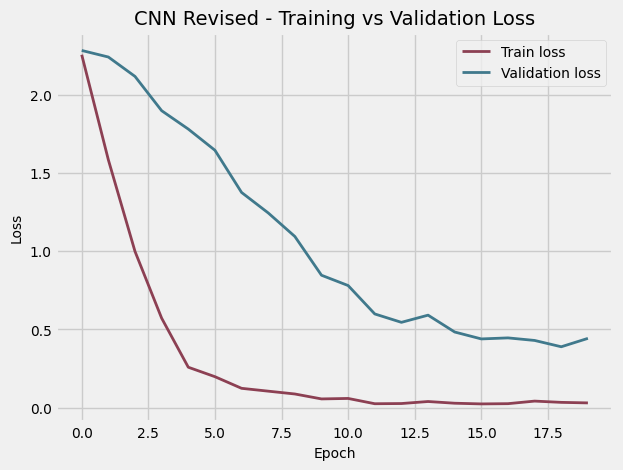

In [46]:
plt.figure()
plt.plot(history_cnn_rev.history['loss'], label='Train loss', color=color_palette[0], linewidth=2)
plt.plot(history_cnn_rev.history['val_loss'], label='Validation loss', color=color_palette[1], linewidth=2)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('CNN Revised - Training vs Validation Loss', fontsize=14)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

In [47]:
# train and validation results
train_loss_cnn_rev, train_acc_cnn_rev = cnn_rev.evaluate(x_train, y_train, verbose=0)
# test set results
test_loss_cnn_rev, test_acc_cnn_rev = cnn_rev.evaluate(x_test, y_test, verbose=0)

print(f"CNN Rev1 - Test Loss: {test_loss_cnn_rev:.4f}")
print(f"CNN Rev1 - Test Accuracy: {test_acc_cnn_rev:.4f}")

CNN Rev1 - Test Loss: 0.3338
CNN Rev1 - Test Accuracy: 0.9639


Επιτυγχάνουμε δηλαδή την ίδια ακρίβεια στα άγνωστα δεδομένα (96.4%) με τα προηγούμενα μοντέλα.

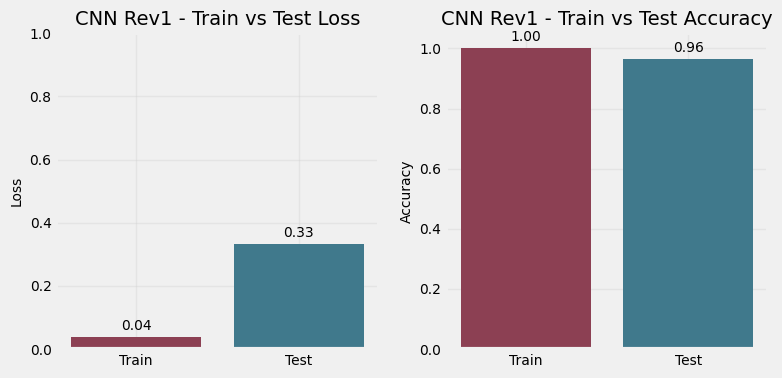

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# loss comparison
sets = ['Train', 'Test']
losses = [train_loss_cnn_rev, test_loss_cnn_rev]
bars = ax1.bar(sets, losses, color=[color_palette[0], color_palette[1]])
ax1.set_ylabel('Loss', fontsize=10)
ax1.set_title('CNN Rev1 - Train vs Test Loss', fontsize=14)
ax1.tick_params(axis='both', labelsize=10)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
ax1.bar_label(bars, fmt='%.2f', padding=3, fontsize=10)

# accuracy comparison
accuracies = [train_acc_cnn_rev, test_acc_cnn_rev]
bars = ax2.bar(sets, accuracies, color=[color_palette[0], color_palette[1]])
ax2.set_ylabel('Accuracy', fontsize=10)
ax2.set_title('CNN Rev1 - Train vs Test Accuracy', fontsize=14)
ax2.tick_params(axis='both', labelsize=10)
ax2.grid(True, alpha=0.3)
ax2.bar_label(bars, fmt='%.2f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

**Ποιό μοντέλο είναι καλύτερο;**

Ας συγκεντρώσουμε παρακάτω τα αποτελέσματά μας:

In [50]:
# Organizing the results into a dictionary
results_data = {
    'Model': ['MLP', 'CNN', 'CNN Revised'],
    'Train Accuracy': [train_acc_mlp, train_acc_cnn, train_acc_cnn_rev],
    'Test Accuracy': [test_acc_mlp, test_acc_cnn, test_acc_cnn_rev],
    'Train Loss': [train_loss_mlp, train_loss_cnn, train_loss_cnn_rev],
    'Test Loss': [test_loss_mlp, test_loss_cnn, test_loss_cnn_rev]
}

df_results = pd.DataFrame(results_data)

df_results.set_index('Model', inplace=True)

print(df_results)

             Train Accuracy  Test Accuracy  Train Loss  Test Loss
Model                                                            
MLP                     1.0       0.969072    0.053339   0.362488
CNN                     1.0       0.969072    0.000126   0.572465
CNN Revised             1.0       0.963918    0.037499   0.333788


Από τα αποτελέσματα φαίνεται πως και τα τρία μοντέλα έχουν ίδια απόδοση στην ακρίβεια - δεν έχουμε πετύχει κάποια βελτίωση δηλαδή.

Καθώς όμως στην πράξη δεν έχουμε δει βελτίωση στην ακρίβεια, θα κρίνουμε τα μοντέλα από τη σκοπιά του χρόνου εκπαίδευσης, και άρα των πόρων (π.χ. σε ενέργεια) που απαιτούνται:

- Το MLP πετυχαίνει σταθεροποίηση της ακρίβειας του validaion set έπειτα από 25 κύκλους, διάρκειας ~1 δευτερολέπτου ο καθένας, σύνολο δηλαδή 25 δευτερόλεπτα.
- Το πρώτο μοντέλο CNN σταθεροποιείται μετά από 6 κύκλους διάρκειας ~5 δευτερολέπτων, άρα παρόμοιο σύνολο με 30 δευτερόλεπτα.
- Το τρίτο μοντέλο (CNN Rev) σταθεροποιείται μετά από 15 κύκλους ~17 δευτερολέπτων (σύνολο 255), άρα απορρίπτεται.

Γνωρίζω όμως από τη θεωρία πως τα Συνελικτικά Νευρωνικά είναι προτιμότερα για την εκπαίδευση σε εικόνες, γιατί μπορούν και επεξεργάζονται δισδιάστατους πίνακες, λαμβάνουν υπόψιν δηλαδή τη χωρική διάσταση των δεδομένων εισόδου. Αντίθετα, στα Multi Layer Perceptron μοντέλα δεν μπορούμε να δουλέψουμε με δισδιάστατους πίνακες και επιπεδώνουμε σε διανύσματα χάνοντας χρήσιμη πληροφορία: στο διάνυσμα ένα ψηφίο (pixel) έχει μόνο δύο άλλα γειτονικά ενώ στην εικόνα έχει οκτώ. Θα επιλέξω επομένως το πρώτο Συνελικτικό Νευρωνικό Μοντέλο, τρέχοντας ενδεχομένως λιγότερους κύκλους κατά το inference, για την εξοικονόμηση πόρων.